In [31]:
from __future__ import division
from WikiCatUtils import (
    get_fullpath,         
    read_categories,      
    load_obj,             
    ArticlePage,          
    CategoryPage,         
    Cache,                
    Representer,          
    Model,
    tokenize,
)                       
from os.path import join


# Analyses to run:
# Generalization to pages in existing categories (already done through CV, report results)
# Visualize which categories are close to each other (t-SNE, PCA)
# See which features (read: words) are most important to the category:
# - Chi2


In [3]:
# First one: CV score on training data
# This is reported by WikiCatBuild but I'll put it here for posterity
root_dir = get_fullpath('test')
model_fn = join(root_dir, 'model.pkl')                                                                                            
repr_fn = join(root_dir, 'repr.pkl')                                                                                              
cache_dir = join(root_dir, 'cache')                                                                                               
                                                                                                                                  
categories_to_download = read_categories(get_fullpath('example_cats.txt'))                                                      
cache = Cache(cache_dir, verbosity=0)                                                                                
for category_uri in categories_to_download:                                                                                       
    cache.loadCategory(category_uri, only_use_cached=True)                                     
                                                                                                                                                                                                                            
dset, label_map = cache.get_dataset(0.6, 0.2, 0.2)                                                                                

embedder = load_obj(repr_fn)                                                                                                       
dset_represented = {}                                                                                                             
dset_represented['train'] = (embedder.transform(dset['train'][0]),                                                         
                             dset['train'][1])                                                                                    
                                                                                                                                  
                                                                                                                                  
dset_represented['val'] = (embedder.transform(dset['val'][0]),                                                                 
                           dset['val'][1])                                                                                        
dset_represented['test'] = (embedder.transform(dset['test'][0]),                                                               
                           dset['test'][1])                                                                                       
                                                                                                                                  
# Train model                                                                                                                     
model = load_obj(model_fn)                                                                                        
                                                                                                                                                                                                                                           
model.evaluate(dset_represented)                                                                                              


Loading model from /home/zj1992/work/interviews/enlitic/WikiCat/test/repr.pkl
Transforming 635 articles
25532 words were OOV out of 584288 total
Transforming 214 articles
8592 words were OOV out of 207902 total
Transforming 215 articles
11601 words were OOV out of 252389 total
Loading model from /home/zj1992/work/interviews/enlitic/WikiCat/test/model.pkl
Train	Val	Test	CV
0.84	0.83	0.84	0.83 (+/- 0.02)


In [29]:
# Which categories are close to each other
# First let's do a t-SNE and PCA embedding of the articles into 2 dimensions
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne_embedder = TSNE(verbose=1, n_components=2, learning_rate=1000)
tsne_train = tsne_embedder.fit_transform(dset_represented['train'][0])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 635 / 635
[t-SNE] Mean sigma: 0.447683
[t-SNE] Error after 65 iterations with early exaggeration: 18.857579
[t-SNE] Error after 135 iterations: 1.310448


In [7]:
pca_embedder = PCA(n_components=2)
pca_train = pca_embedder.fit_transform(dset_represented['train'][0])

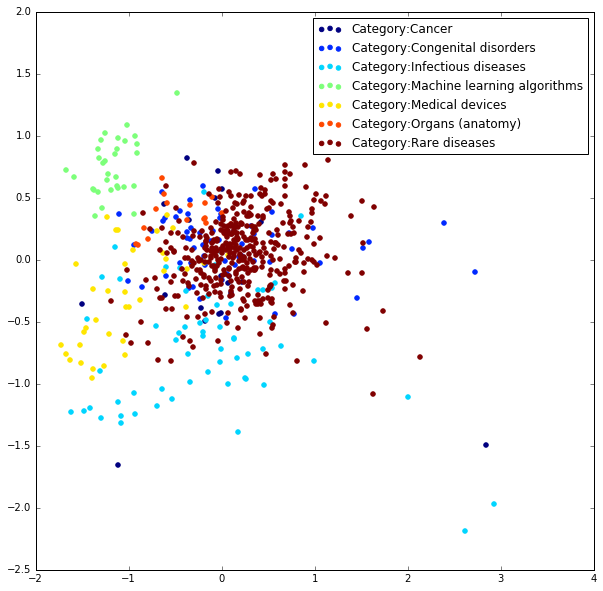

In [22]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_by_class(data, classes, ind_label_map):
    class_cols = np.linspace(0,1,len(ind_label_map))
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for class_ind in ind_label_map:
        locs = np.where(np.array(classes) == class_ind)
        ax.scatter(data[locs,0], data[locs,1], color=plt.cm.jet(class_cols[class_ind]),
                   label=ind_label_map[class_ind])
    ax.legend()
        
        
plot_by_class(pca_train, dset['train'][1], model.ind_label_map)

In [25]:
# Hm, that's pretty awful for a lot of classes, although it's not entirely surprising. It would be good to see
# how many articles listed in the Rare diseases category are also Congenital disorders -- I'd guess there's a
# good amount. For some classes however it's clear that even projecting down to 2 dimensions we have good linear
# separability from these features. However how much of the variance is explained by the first two components of
# the PCA?

pca_all = PCA(n_components=dset_represented['train'][0].shape[1])
pca_all.fit(dset_represented['train'][0])
total_expl_var = 0
counter = 0
for expl_variance in pca_all.explained_variance_ratio_:
    total_expl_var += expl_variance
    counter += 1
    if total_expl_var > 0.95:
        break
#print(total_expl_var)
print(counter)
# So we need 82 components to mostly get the variance out, which is actually kinda high
# Let's look at t-SNE's interpretation

82


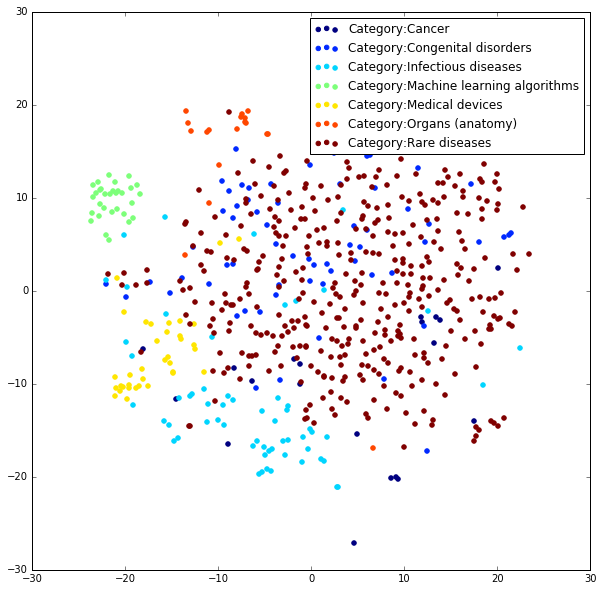

In [30]:
plot_by_class(tsne_train, dset['train'][1], model.ind_label_map)

In [ ]:
# While t-SNE's interpretation looks bad, it's worth noting how many of the categories are easily separated in
# this manifold despite the spread of the rare diseases category. That said, it gives a clearer picture of how
# similar Congenital Disorders, Cancer, and Rare Diseases are

In [47]:
# Next we'll investigate which words distinguish a category from the rest (one-v-rest style)
# using a simplified chi-square statistic

# for each class, we'll look at every article that's in that class and every article that isn't
# then for every term in the vocab, we'll calculate
# tp - number of in-category articles containing the term
# fp - number of in-category articles not containing the term
# tn - number of out-category articles not containing the term
# fn - number of out-category articles containing the term

# then we take (for each term) the tf*chi2 statistic N*(tp*tn - fp*fn)**2 / (tp+fp)*(tn+fn)*(tn+fp)*(tp+fn)

def chi_square(pos_articles, neg_articles, vocab):
    n_articles = len(pos_articles) + len(neg_articles)
    pos_sets = [set(tokenize(article)) for article in pos_articles]
    neg_sets = [set(tokenize(article)) for article in neg_articles]
    chi_squares = {}
    #print("tp\tfp\tfn\ttn")
    for word in vocab:
        #print("Processing word %s" % word)
        tp = len(list(filter(lambda x: word in x, pos_sets)))
        fp = len(pos_sets) - tp
        fn = len(list(filter(lambda x: word in x, neg_sets)))
        tn = len(neg_sets) - fn
        if (tp + fn) == 0:
            # word not actually in any of the articles, skip it
            continue
        #print("%d\t%d\t%d\t%d" % (tp, fp, fn, tn))
        chi_squares[word] = (n_articles*(tp*tn - fp*fn)**2) / ((tp+fp)*(tn+fn)*(tn+fp)*(tp+fn))
    return chi_squares

def get_chi_square_scores(articles, classes, ind_class_map, vocab):
    articles_np = np.array(articles) # so we can use that sweet, sweet fancy indexing
    classes_np = np.array(classes)
    class_chis_map = {}
    for class_ind in ind_class_map:
        tic = time.time()
        pos_set = articles_np[np.where(classes_np == class_ind)]
        neg_set = articles_np[np.where(classes_np != class_ind)]
        class_chis_map[class_ind] = chi_square(pos_set, neg_set, vocab)
        toc = time.time() - tic
    return class_chis_map

class_chisq = get_chi_square_scores(dset['train'][0], dset['train'][1], model.ind_label_map, 
                                    embedder.vocab)


In [56]:
pprint = lambda x: '\n'.join(['\t%s: %0.2f' % i for i in x])

for class_ind in model.ind_label_map:
    print("%s\n%s" % (model.ind_label_map[class_ind], 
                      pprint(sorted(class_chisq[class_ind].items(), key=lambda x: -x[1])[:5])))

Category:Cancer
	anticancer: 217.65
	colorectal: 177.65
	cancers: 166.68
	hepatocellular: 154.97
	cancer: 141.52
Category:Congenital disorders
	congenital: 63.24
	teratology: 36.55
	lissencephaly: 36.53
	sotos: 36.53
	tibia: 29.96
Category:Infectious diseases
	infectious: 267.42
	tuberculosis: 177.49
	pathogen: 134.10
	measles: 133.83
	infected: 116.62
Category:Machine learning algorithms
	algorithm: 488.22
	learning: 253.44
	algorithms: 241.27
	computational: 201.43
	machine: 196.65
Category:Medical devices
	device: 371.06
	devices: 259.85
	industry: 196.66
	companies: 188.47
	company: 163.71
Category:Organs (anatomy)
	grays: 350.43
	fma: 348.26
	identifiers: 348.26
	vertebrates: 310.35
	elsevier: 264.49
Category:Rare diseases
	resources: 187.00
	omim: 171.35
	rare: 168.41
	classification: 150.51
	disorder: 129.86


In [ ]:
# Some of these are weird -- especially rare diseases, which seems have artifacts from the article rather than
# the true text of it as a major distinguishing factor, e.g. resources, classification, and omim, which is
# presumably: https://en.wikipedia.org/wiki/Online_Mendelian_Inheritance_in_Man, which is referenced in a lot
# of articles about rare diseases. This is most likely because of the overwhelming amount of rare disease
# articles compared to the relatively miniature amount of articles for every other category.

# Essentially the gist of what I can see from this is that sometimes the most distinguishing words are 
# regularities that stem from the structure of articles generally in a particular category. A more intricate
# attempt at scraping could probably remove these regularities.

In [109]:
# Let's see if the semantic space for these words (we'll take the top 50 by chi-square score) separates them
# by class as well as we'd hope.

from itertools import chain
from sklearn.utils import shuffle
def get_best_wordset(chi2_scores, vocab, limit=50):
    top_n = [vocab[word].reshape(1,vocab[word].shape[0]) for word in 
                       sorted(chi2_scores.keys(), key=lambda x: -1*chi2_scores[x])][:limit]
    return top_n
    
word_dataset = [[],[]]
for class_ind in model.ind_label_map:
    to_add = get_best_wordset(class_chisq[class_ind], embedder.vocab, limit=50)
    word_dataset[0] = chain(word_dataset[0], to_add)
    word_dataset[1] = chain(word_dataset[1], [class_ind]*len(to_add))
    
word_dataset[0] = np.vstack(word_dataset[0])
word_dataset[0] = (word_dataset[0] - embedder.mins) / (embedder.maxes - embedder.mins)
word_dataset[1] = np.array(list(word_dataset[1]))
word_dataset = shuffle(*word_dataset)

In [110]:
word_tsne = tsne_embedder.fit_transform(word_dataset[0])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 4.777800
[t-SNE] Error after 100 iterations with early exaggeration: 18.282364
[t-SNE] Error after 160 iterations: 1.739389


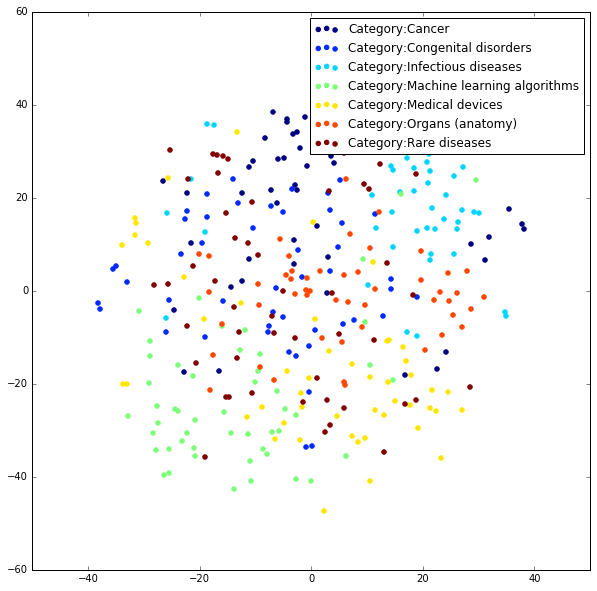

In [111]:
plot_by_class(word_tsne, word_dataset[1], model.ind_label_map)

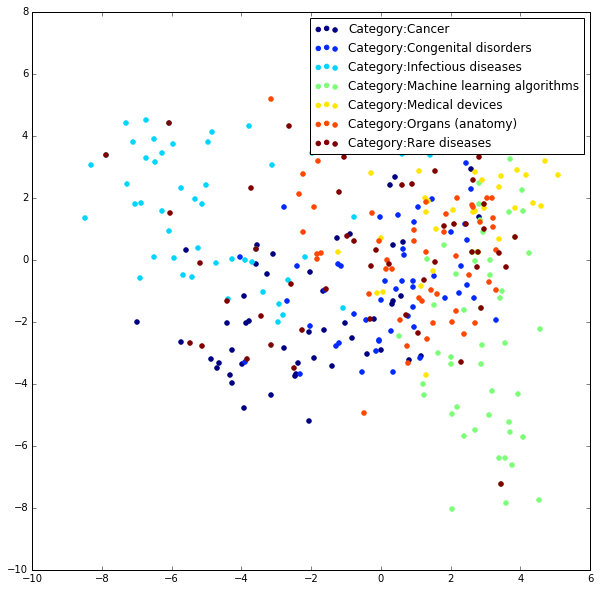

In [112]:
word_pca = pca_embedder.fit_transform(word_dataset[0])
plot_by_class(word_pca, word_dataset[1], model.ind_label_map)

In [113]:
# So essentially what's happening here is that it's clear that the Chi^2 scores, while showing which words
# distinguish each class, don't do as great of a job of separating these categories by their words in the
# embedding space.

# To further test this, let's see what happens when we run the classifier on each of these words

In [114]:
print("Average accuracy for predicting category based on word %0.2f" % model.score(word_dataset))
# Let's also try making 'articles' by averaging the top-50 words by Chi2
for class_ind in model.ind_label_map:
    fake_article = np.average(word_dataset[0][np.where(word_dataset[1] == class_ind)], axis=0)
    model_prediction = model.predict([fake_article]).reshape(1)
    print("Model prediction: %s, true category: %s" % (model.ind_label_map[model_prediction[0]],
                                                       model.ind_label_map[class_ind]))
    

Average accuracy for predicting category based on word 0.72
Model prediction: Category:Cancer, true category: Category:Cancer
Model prediction: Category:Congenital disorders, true category: Category:Congenital disorders
Model prediction: Category:Infectious diseases, true category: Category:Infectious diseases
Model prediction: Category:Machine learning algorithms, true category: Category:Machine learning algorithms
Model prediction: Category:Medical devices, true category: Category:Medical devices
Model prediction: Category:Organs (anatomy), true category: Category:Organs (anatomy)
Model prediction: Category:Rare diseases, true category: Category:Rare diseases


In [108]:
# It's notable that predicting just based on the word doesn't do too hot, but the average word set is perfect
# (though it's not clear how statistically significant this is). This implies that there is
# actually some interaction between words that would help distinguish the category to the model that takes place
# when averaging the vectors together.